This notebook considers a simple HMM with a single state variable (taking values of 0 or 1) and a Gaussian emission. 

Goal is to perform inference using NUTS with discrete variables elimination as shown in [hmm_enum.py](https://github.com/pyro-ppl/numpyro/blob/master/examples/hmm_enum.py). 

Issue with the aforementioned example is that it seems to only learn the parameters of the HMM and stopping before decoding the state sequence.

In this notebook I rather desperately try a couple of ways:

1. ``Predictive``
    1. With ``infer_discrete=False`` (what does it actually yield?)
    2. With ``infer_discrete=True`` (errors)
2. Using ``contrib.funsor.infer_discrete``
    1. On the model as is (errors the same way)
    2. On the model without continuous variables (errors differently)
    3. On the model with ``contrib.funsor.markov`` for-loop instead of ``contrib.control_flow.scan`` (actually **works**)

In [1]:
import numpyro 
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import mask
from numpyro.contrib.funsor import infer_discrete, config_enumerate, markov
from numpyro.contrib.control_flow import scan
from jax import jit, random, numpy as np
import matplotlib.pyplot as plt
rng_key = random.PRNGKey(0)

In [2]:
nt = 20
trans_prior = 0.6 * np.eye(2) + 0.2
mu = np.array([1, 10])
sigma = np.array([0.1, 2])

In [3]:
def model_scan(trans, obs=None, n=None):
    """ Vanilla HMM with Gaussian observations """
    s0 = numpyro.sample(
        "s0",
        dist.Categorical(np.ones(2) / 2),
    )
    probs_trans = numpyro.sample(
        "trans", dist.Dirichlet(trans).to_event(1)
    )
        
    def transition(s_prev, y_obs):
        s = numpyro.sample("s", dist.Categorical(probs_trans[s_prev]))
        y = numpyro.sample("y", dist.Normal(mu[s], sigma[s]), obs=y_obs)
        return s, (s, y)

    _, (s, y) = scan(
        transition,
        s0,
        obs,
        length=n
    )
    return (s, y)

# Generate data
Simulate 10 chains and chose one with some action

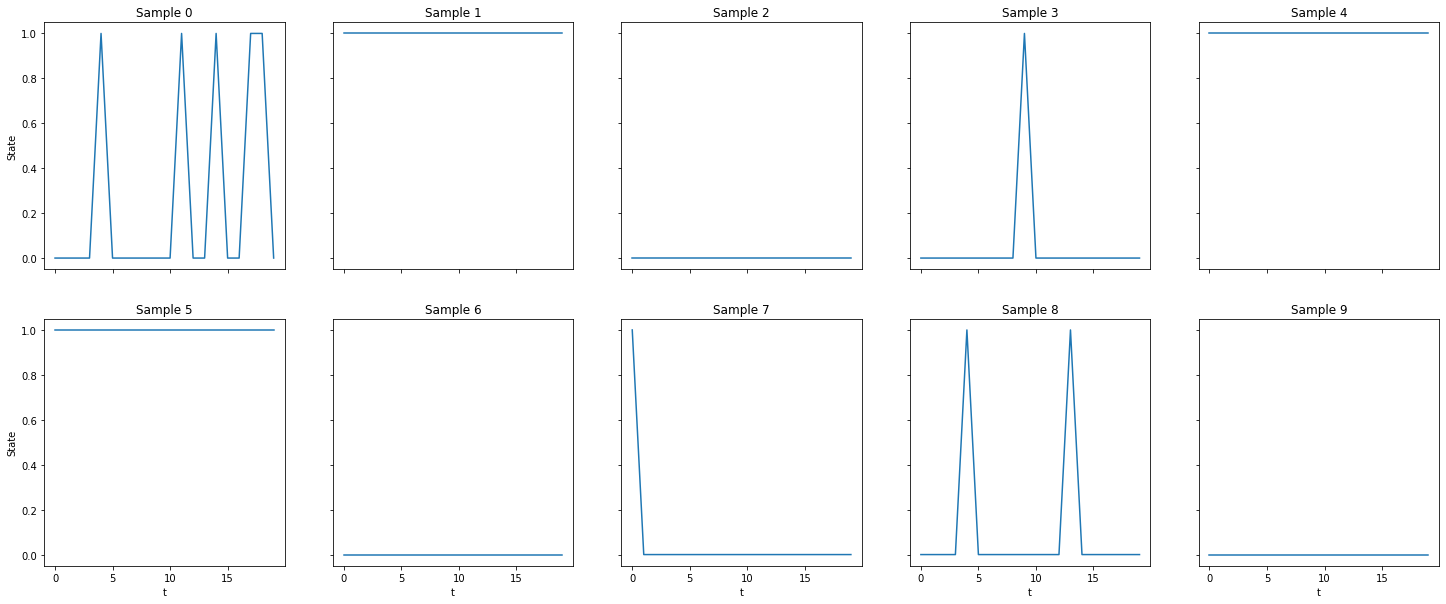

In [4]:
predictive = Predictive(model_scan, num_samples=10, parallel=True)
samples = predictive(rng_key, trans_prior, n=nt)
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(25, 10), sharex=True, sharey=True)
for idx, (ax, s) in enumerate(zip(axes.flat, samples["s"])):
    ax.plot(s, label="s")
    ax.set_title(f"Sample {idx}")
for ax in axes[:, 0]:
    ax.set_ylabel("State")
for ax in axes[1]:
    ax.set_xlabel("t")

In [5]:
idx = 0
s_gt, y_obs = samples["s"][idx], samples["y"][idx] 

Text(0, 0.5, 'y')

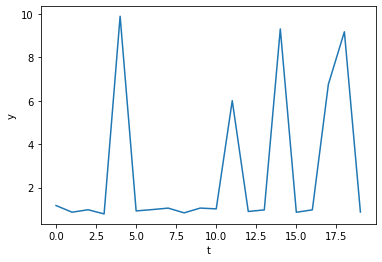

In [6]:
plt.plot(y_obs)
plt.xlabel("t")
plt.ylabel("y")

# Learn model's continuous parameters with NUTS + enumeration

In [7]:
kernel = NUTS(config_enumerate(model_scan))
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=2,
)
rng_key, _ = random.split(rng_key)
mcmc.run(rng_key, trans_prior, y_obs)

/data/envs/tmp-669889451323acd/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█| 1000/1000 [00:00<00:00, 2013.70it/s, 3 steps of size 8.87e-01. acc. prob=0.92]


In [8]:
posterior = mcmc.get_samples()
print(posterior.keys())
mcmc.print_summary()

dict_keys(['trans'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
trans[0,0]      0.74      0.11      0.75      0.58      0.91    905.10      1.00
trans[0,1]      0.26      0.11      0.25      0.09      0.42    905.10      1.00
trans[1,0]      0.72      0.17      0.75      0.49      0.99    651.86      1.00
trans[1,1]      0.28      0.17      0.25      0.01      0.51    651.86      1.00

Number of divergences: 0


# Goal: infer discrete states
## 1. Predictive? 
### 1.A. Predictive with ``infer_discrete=False``

In [9]:
rng_key, _ = random.split(rng_key, 2)
predictive = Predictive(
    config_enumerate(model_scan), 
    posterior_samples=mcmc.get_samples(), 
    parallel=True,
    infer_discrete=False,
)
# not passing any observations in this instance
# but doint so only changes the predictive for y (below), not s
samples = predictive(rng_key, trans_prior, n=nt) 

In [10]:
samples.keys()

dict_keys(['s', 's0', 'y'])

I get samples of discrete sites. Are they informative?

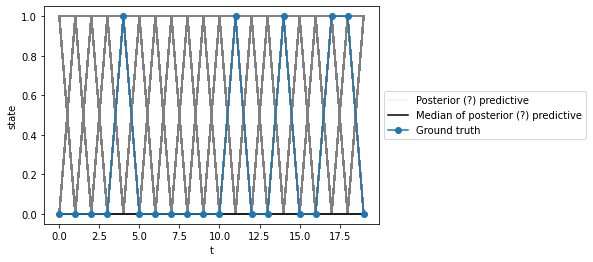

In [11]:
plt.plot(samples["s"][0], c="grey", alpha=0.1, label="Posterior (?) predictive");
plt.plot(samples["s"].T, c="grey", alpha=0.1);
plt.plot(np.median(samples["s"], axis=0), c="k", label="Median of posterior (?) predictive");
plt.plot(s_gt, marker="o", label="Ground truth")
plt.ylabel("state")
plt.xlabel("t")
plt.legend(bbox_to_anchor=(1., .5), loc="center left")

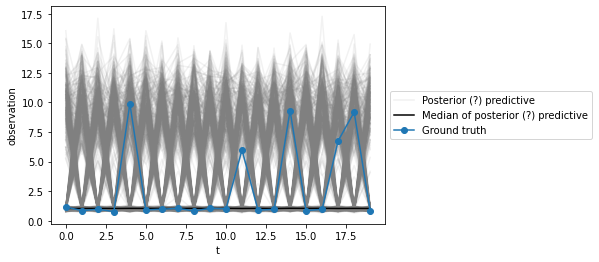

In [12]:
plt.plot(samples["y"][0], c="grey", alpha=0.1, label="Posterior (?) predictive");
plt.plot(samples["y"].T, c="grey", alpha=0.1);
plt.plot(np.median(samples["y"], axis=0), c="k", label="Median of posterior (?) predictive");
plt.plot(y_obs, marker="o", label="Ground truth")
plt.ylabel("observation")
plt.xlabel("t")
plt.legend(bbox_to_anchor=(1., .5), loc="center left")

Does not seems so

### 1.B. Predictive with ``infer_discrete=True``
Fails

In [13]:
rng_key, _ = random.split(rng_key, 2)
predictive = Predictive(
    config_enumerate(model_scan), 
    posterior_samples=mcmc.get_samples(), 
    parallel=True,
    infer_discrete=True
)
samples = predictive(rng_key, trans_prior, n=nt)

AssertionError: 

## 2. Using ``contrib.funsor.infer_discrete`` 
### 2.A. On the original model, still containing continuous parameters

Fails in the same way

In [14]:
rng_key, _ = random.split(rng_key, 2)
infer_states = infer_discrete(
    config_enumerate(model_scan), 
    first_available_dim=-1, 
    temperature=0, 
    rng_key=rng_key
)
states = infer_states(trans_prior, y_obs)

AssertionError: 

### 2.B. Original model without continuous parameters
Sample sites manually swapped for the mean of the posterior (since masking them as in the ``hmm_enum.py`` did not help)

Fails differently

In [15]:
def model_scan(trans, obs=None, n=None):
    s0 = numpyro.sample(
        "s0",
        dist.Categorical(np.ones(2) / 2),
    )
        
    def transition(s_prev, y_obs):
        s = numpyro.sample("s", dist.Categorical(trans[s_prev]))
        y = numpyro.sample("y", dist.Normal(mu[s], sigma[s]), obs=y_obs)

        return s, (s, y)

    _, (s, y) = scan(
        transition,
        s0,
        obs,
        length=n
    )
    return (s, y)

In [16]:
infer_states = infer_discrete(
    config_enumerate(model_scan), 
    first_available_dim=-1, 
    temperature=0, 
    rng_key=rng_key
)
rng_key, _ = random.split(rng_key, 2)
trans_post = posterior["trans"].mean(axis=0)
states = infer_states(trans_post, y_obs)

AssertionError: 

### 2.C. Using ``markov`` instead of ``scan``, while not having continuous parameters
Actually works

In [17]:
def model_markov(trans, obs=None, n=None):
    if obs is None:
        if n is None:
            raise ValueError("if obs is not given, n is required")
        obs = [None] * n
    else:
        n = len(obs)
    s0 = numpyro.sample(
        "s_0",
        dist.Categorical(np.ones(2) / 2),
    )
    y0 = numpyro.sample("y_0", dist.Normal(mu[s0], sigma[s0]), obs=obs[0])
    
    states = [s0]
    for t in markov(range(1, n)):
        s = numpyro.sample(f"s_{t}", dist.Categorical(trans[states[-1]]))
        y = numpyro.sample(f"y_{t}", dist.Normal(mu[s], sigma[s]), obs=obs[t])
        
        states.append(s)
    return states

In [18]:
rng_key, _ = random.split(rng_key, 2)
infer_states = infer_discrete(
    config_enumerate(model_markov), 
    first_available_dim=-1, 
    temperature=0, 
    rng_key=rng_key
)
states = np.array(infer_states(trans_post, y_obs))

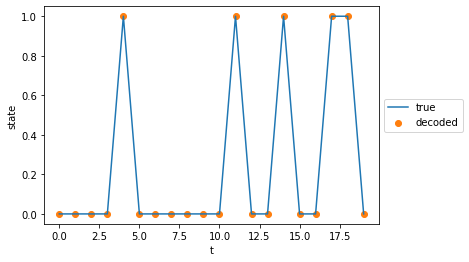

In [19]:
t = np.arange(len(s_gt))

plt.plot(t, s_gt, label="true")
plt.scatter(t, states, label="decoded", c="C1")
plt.ylabel("state")
plt.xlabel("t")
plt.legend(bbox_to_anchor=(1., .5), loc="center left")